<a href="https://colab.research.google.com/github/GauravPatel89/EVA-Track3-Assignments/blob/master/Session7/Session7B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import neceesary modules

from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D,SeparableConv2D,Conv2D
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda, GlobalAveragePooling2D, AveragePooling2D, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils, plot_model

from keras.models import Model
from keras.layers import Input
from keras.layers.merge import concatenate,Add

Using TensorFlow backend.


In [2]:
# Import and load cifar10 dataset

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 11s 0us/step


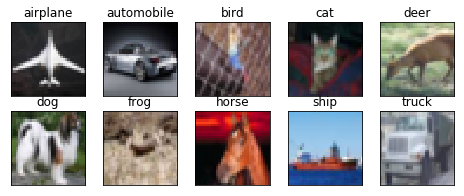

In [3]:
# Display randomly selected examples from each of the classes

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Define a function to plot training and test accuracies and losses during the training

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
# define a function to calculate accuracy based on passed model, test data and test labels

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
# Stadandardize the data by converting it to float32 and dividing by max pixel value 255

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels in one hot encoding
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Strategy
If we look at the ENAS generated CIFAR-10 model, we see that there are lots of skip connections. These connections are from layers appearing earlier in the model to the later layers. Number of skip connections are as high as 7 to some layers. These connections are concatenated together and fed as input to the layer. So one major problem we will encounter is matching the shape (size and number of channels) of the channels. In order to concatenate channels the must have same size. Now convolution layers in the network have padding so they will not reduce the channel sizes hence only maxPooling layers will reduce the channel size. So we will have larger size channels coming in to be merged with smaller size channels. We solve this issue by using 'Space to Depth algorithm. 

To implement the skip connections so that model design looks self explaining and uncluttered, we have defined a function **adjustInputsAndConcate(refInput, inputList)**. It takes as input reference channel (***refInput***) i.e. target channel with required size(This is the regular input coming from output of previous layer) and ***inputList*** i.e. skip connections to be merged along with ***refInput***. The function will apply space-to-depth algorithm on each of the inputs in the ***inputList*** to match its size with that of ***refInput*** and concatenate all the modified innputs with ***refInput*** and return it.

Usage:

In<sub>1</sub>  | Layer1 | Out<sub>1</sub> 

Out<sub>1</sub> | Layer2 | Out<sub>2</sub> 

Out<sub>2</sub> | Layer3 | Out<sub>3</sub> 

Out<sub>1</sub> + Out<sub>2</sub> + Out<sub>3</sub>| Layer4 | Out<sub>4</sub>

In this case we can use adjustInputsAndConcate as

adjustInputsAndConcate(Out<sub>3</sub>, [Out<sub>1</sub>, Out<sub>2</sub>]) | Layer4 | Out<sub>4</sub>


In order to make Model layout easier to understand each layers are numbered as layer1, layer2 ... soon. Also each layers are named as 'L<layer number>_OperationSizexSize' eg. L1_Sep5x5. 
  
The function adjustInputsAndConcate also names the concatenate layer based on layers that are concatenated. eg. Suppose Layers 1,2,3 and 4 are merged with 4 being the reference channel concatenate layer will be named 'Concate_L4_L3_L2_L1'.

In [0]:
import tensorflow as tf
# this function uses space to depth algo to match shapes of inputs in inputList with refInput (reference)

def adjustInputsAndConcate(refInput, inputList):
  #print("reference Channel --> = {}".format(refInput))
  shapeAdjustedList = [refInput]
  concateLayerName = 'Concate_' + refInput.name.split('_')[0]
  for i in inputList:
    #print("Processing {}".format(i))
    # calculate factor by which the size needs to be reduced
    s2dFactor = (i.shape[1])//(refInput.shape[1])
    #print(s2dFactor)
    # Generate the Concatenation layer name by appending the layer names being concatenated
    concateLayerName = concateLayerName + '_' + i.name.split('_')[0]
    # Apply space to depth only if the calculated factor is more than equal to 2 else append the input unchanged
    if s2dFactor >=2:
      shapeAdjustedList.append(Lambda(tf.space_to_depth, arguments={'block_size':s2dFactor},)(i))      
    else :
      shapeAdjustedList.append(i) 
      
    concatedOut = concatenate(shapeAdjustedList, name= concateLayerName)
  #print(concateLayerName)
  return concatedOut    
 












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
L1_Sep5x5 (SeparableConv2D)     (None, 32, 32, 32)   203         input_1[0][0]                    
__________________________________________________________________________________________________
L1_BN (BatchNormalization)      (None, 32, 32, 32)   128         L1_Sep5x5[0][0]                  
__________________________________________________________________________________________________
L1_Relu (Activation)            (None, 32, 32, 32)   0          

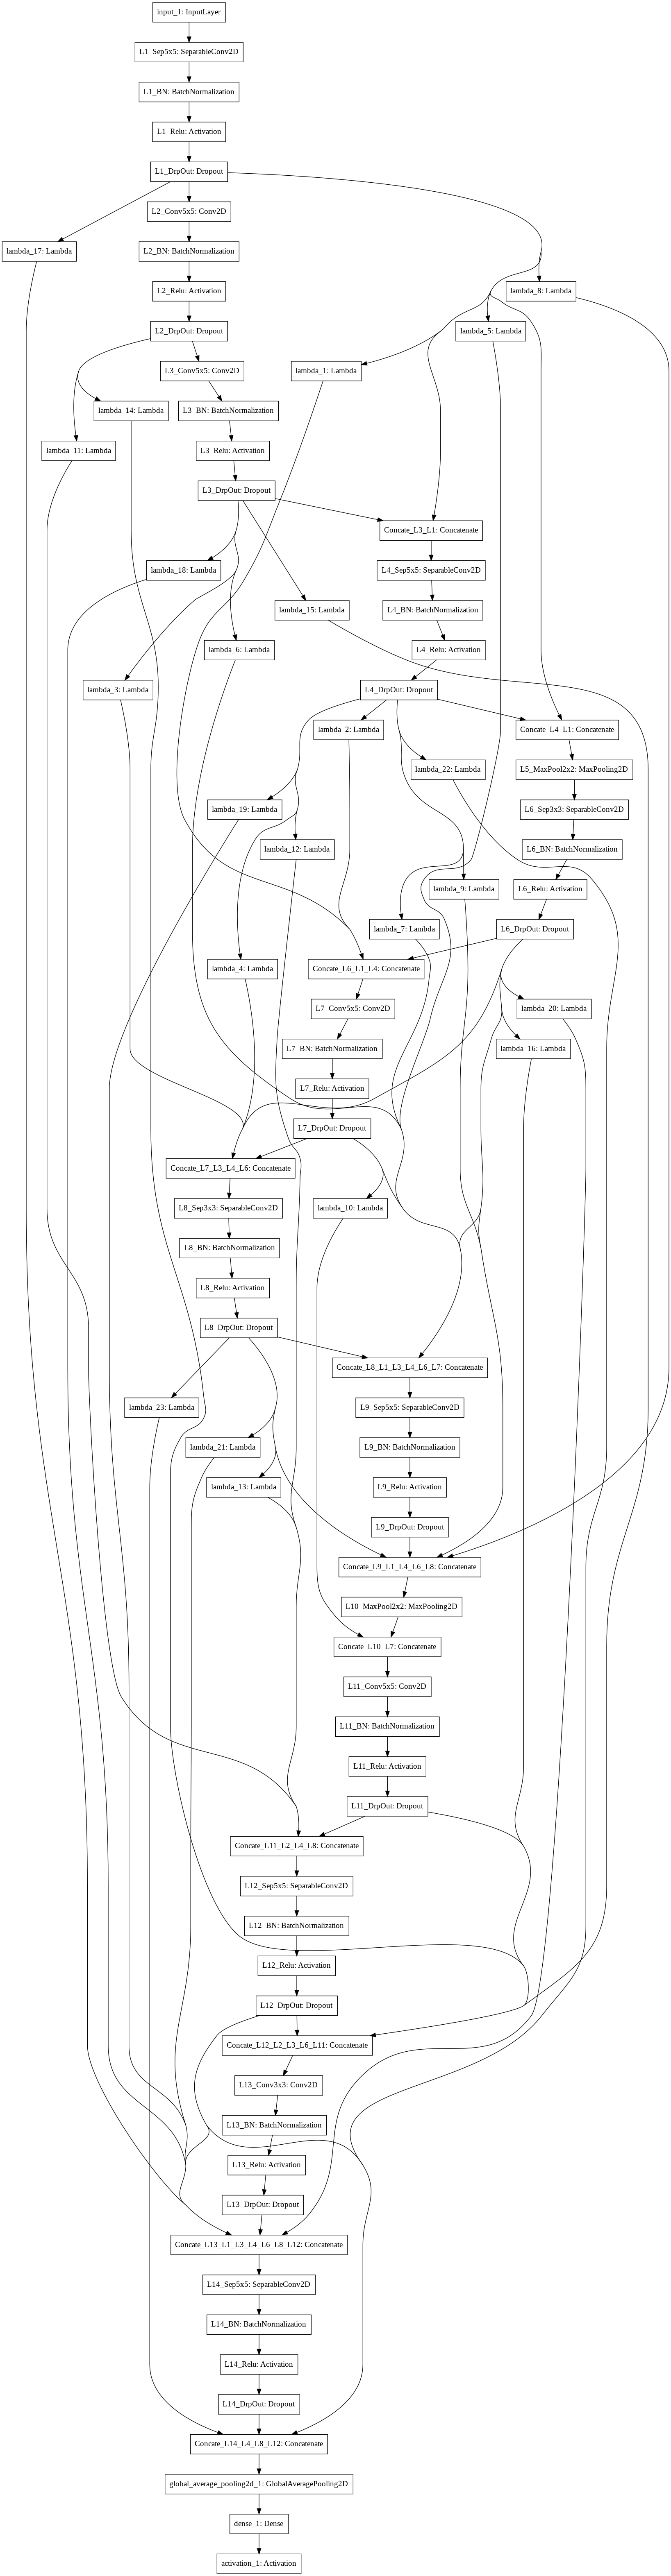

In [9]:
from keras import regularizers
regLambda = 0.02

# Input layer 
inputLayer = Input(shape=(32,32,3)) #32

layer1 = SeparableConv2D(32, kernel_size = 5, padding='same', name = 'L1_Sep5x5',
                         kernel_regularizer=regularizers.l2(regLambda))(inputLayer)   #
layer1 = BatchNormalization(name = 'L1_BN')(layer1)
layer1 = Activation('relu', name = 'L1_Relu')(layer1)
layer1 = Dropout(0.05, name = 'L1_DrpOut')(layer1)


layer2 = Conv2D(32, kernel_size = 5, padding='same', name = 'L2_Conv5x5',
                kernel_regularizer=regularizers.l2(regLambda))(layer1)   
layer2 = BatchNormalization( name = 'L2_BN')(layer2)
layer2 = Activation('relu', name = 'L2_Relu')(layer2)
layer2 = Dropout(0.1, name = 'L2_DrpOut')(layer2)

layer3 = Conv2D(32, kernel_size = 5, padding='same', name = 'L3_Conv5x5',
                kernel_regularizer=regularizers.l2(regLambda))(layer2)   # 
layer3 = BatchNormalization(name = 'L3_BN')(layer3)
layer3 = Activation('relu',name = 'L3_Relu')(layer3)
layer3 = Dropout(0.1, name = 'L3_DrpOut')(layer3)

layer4 = SeparableConv2D(32, kernel_size = 5, padding='same', name = 'L4_Sep5x5',
                         kernel_regularizer=regularizers.l2(regLambda))(adjustInputsAndConcate(layer3,[layer1]))   # Skip connections from layer1
layer4 = BatchNormalization(name = 'L4_BN')(layer4)
layer4 = Activation('relu',name = 'L4_Relu')(layer4)
layer4 = Dropout(0.15, name = 'L4_DrpOut')(layer4)

layer5 = MaxPooling2D(pool_size=(2, 2), name = 'L5_MaxPool2x2')(adjustInputsAndConcate(layer4,[layer1]))           # Skip connections from layer1

layer6 = SeparableConv2D(64, kernel_size = 3, padding='same', name = 'L6_Sep3x3',
                         kernel_regularizer=regularizers.l2(regLambda))(layer5)   # 
layer6 = BatchNormalization(name = 'L6_BN')(layer6)
layer6 = Activation('relu',name = 'L6_Relu')(layer6)
layer6 = Dropout(0.15, name = 'L6_DrpOut')(layer6)

layer7 = Conv2D(64, kernel_size = 5, padding='same', name = 'L7_Conv5x5',                            # Skip connections from layer1, layer4
                kernel_regularizer=regularizers.l2(regLambda))(adjustInputsAndConcate(layer6,[layer1, layer4]))    
layer7 = BatchNormalization(name = 'L7_BN')(layer7)
layer7 = Activation('relu',name = 'L7_Relu')(layer7)
layer7 = Dropout(0.2, name = 'L7_DrpOut')(layer7)

layer8 = SeparableConv2D(64, kernel_size = 3, padding='same', name = 'L8_Sep3x3',                    # Skip connections from layer3, layer4, layer6
                         kernel_regularizer=regularizers.l2(regLambda))(adjustInputsAndConcate(layer7,[layer3, layer4, layer6])) 
layer8 = BatchNormalization(name = 'L8_BN')(layer8)
layer8 = Activation('relu',name = 'L8_Relu')(layer8)
layer8 = Dropout(0.2, name = 'L8_DrpOut')(layer8)

layer9 = SeparableConv2D(64, kernel_size = 5, padding='same', name = 'L9_Sep5x5',                    # Skip connections from layer1, layer3, layer4, layer 6, layer7
                         kernel_regularizer=regularizers.l2(regLambda))(adjustInputsAndConcate(layer8,[layer1, layer3, layer4, layer6, layer7]))    
layer9 = BatchNormalization(name = 'L9_BN')(layer9)
layer9 = Activation('relu',name = 'L9_Relu')(layer9)
layer9 = Dropout(0.25, name = 'L9_DrpOut')(layer9)

layer10 = MaxPooling2D(pool_size=(2, 2),name = 'L10_MaxPool2x2')(adjustInputsAndConcate(layer9,[layer1, layer4, layer6, layer8])) # Skip connections from layer1, layer4, layer 6, layer8

layer11 = Conv2D(128, kernel_size = 5, padding='same', name = 'L11_Conv5x5',                    # Skip connections from layer7 
                 kernel_regularizer=regularizers.l2(regLambda))(adjustInputsAndConcate(layer10,[layer7]))   # 
layer11 = BatchNormalization(name = 'L11_BN')(layer11)
layer11 = Activation('relu',name = 'L11_Relu')(layer11)
layer11 = Dropout(0.25, name = 'L11_DrpOut')(layer11)

layer12 = SeparableConv2D(128, kernel_size = 5, padding='same', name = 'L12_Sep5x5',            # Skip connections from layer2, layer4, layer8
                          kernel_regularizer=regularizers.l2(regLambda))(adjustInputsAndConcate(layer11,[layer2, layer4, layer8]))   # 
layer12 = BatchNormalization(name = 'L12_BN')(layer12)
layer12 = Activation('relu',name = 'L12_Relu')(layer12)
layer12 = Dropout(0.30, name = 'L12_DrpOut')(layer12)

layer13 = Conv2D(128, kernel_size = 3, padding='same', name = 'L13_Conv3x3',                    # Skip connections from layer2, layer3, layer6, layer11
                 kernel_regularizer=regularizers.l2(regLambda))(adjustInputsAndConcate(layer12,[layer2, layer3, layer6, layer11]))   # 
layer13 = BatchNormalization(name = 'L13_BN')(layer13)
layer13 = Activation('relu',name = 'L13_Relu')(layer13)
layer13 = Dropout(0.35, name = 'L13_DrpOut')(layer13)

layer14 = SeparableConv2D(128, kernel_size = 5, padding='same', name = 'L14_Sep5x5',            # Skip connections from layer1, layer3, layer4, layer 6, layer8, layer12
                          kernel_regularizer=regularizers.l2(regLambda))(adjustInputsAndConcate(layer13,[layer1, layer3, layer4, layer6, layer8, layer12]))   # 
layer14 = BatchNormalization(name = 'L14_BN')(layer14)
layer14 = Activation('relu', name = 'L14_Relu')(layer14)
layer14 = Dropout(0.40, name = 'L14_DrpOut')(layer14)

layer15 = GlobalAveragePooling2D()(adjustInputsAndConcate(layer14,[layer4, layer8, layer12]))   # Skip connections from layer4, layer8, layer12
layer16 = Dense(10)(layer15)
outputLayer = Activation('softmax')(layer16)


model = Model(inputs=inputLayer, outputs=outputLayer)
# summarize layers
print(model.summary())
# plot graph
plot_model(model)




In [10]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
# Use keras ImageDataGenerator to obtain normalized training and testing data batches

from keras.preprocessing.image import ImageDataGenerator


# Initialize ImageDataGenerator for image normalization for training
datagen = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, zoom_range=0.0, 
                             horizontal_flip=False)

# Learn stats of training data eg. mean, std
datagen.fit(train_features)

# Define batch size
BS=128
# Generate an iterator for training. It will provide nomalized image data of size BS for training
train_iterator = datagen.flow(train_features, train_labels, batch_size = BS)

# Since we will train the model on normalized image data we must used normalized images for validation as well
# Initialize ImageDataGenerator for image normalization for testing
datagenTest = ImageDataGenerator(featurewise_center=True, featurewise_std_normalization=True, zoom_range=0.0, 
                             horizontal_flip=False)

# Learn stats of testing data eg. mean, std
datagenTest.fit(test_features)


# Generate an iterator for training. It will provide nomalized image data of size BS for testing
test_iterator = datagenTest.flow(test_features, test_labels, batch_size = BS)

In [13]:
from google.colab import drive
from keras.callbacks import ModelCheckpoint
  
# mount google drive to save  model
drive.mount('/content/gdrive')


fileNameWeights = '/content/gdrive/My Drive/TSAI/Session7/ModelCopySes7B2BestModelWeights.h5'

# save model weights to 'fileNameWeights' each time the validation accuracy improves
checkpoint = ModelCheckpoint(fileNameWeights, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=True, mode='max')
callbacks_list = [checkpoint]

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


Epoch 1/100
390/390 [==============================] - 136s 349ms/step - loss: 1.8072 - acc: 0.5086 - val_loss: 1.4095 - val_acc: 0.5495

Epoch 00001: val_acc improved from -inf to 0.54948, saving model to /content/gdrive/My Drive/TSAI/Session7/ModelCopySes7B2BestModelWeights.h5
Epoch 2/100
390/390 [==============================] - 126s 323ms/step - loss: 1.1326 - acc: 0.6405 - val_loss: 1.8644 - val_acc: 0.4721

Epoch 00002: val_acc did not improve from 0.54948
Epoch 3/100
390/390 [==============================] - 126s 322ms/step - loss: 0.9861 - acc: 0.6952 - val_loss: 1.0460 - val_acc: 0.6683

Epoch 00003: val_acc improved from 0.54948 to 0.66825, saving model to /content/gdrive/My Drive/TSAI/Session7/ModelCopySes7B2BestModelWeights.h5
Epoch 4/100
390/390 [==============================] - 126s 322ms/step - loss: 0.8987 - acc: 0.7274 - val_loss: 1.1655 - val_acc: 0.6494

Epoch 00004: val_acc did not improve from 0.66825
Epoch 5/100
390/390 [==============================] - 126s 3

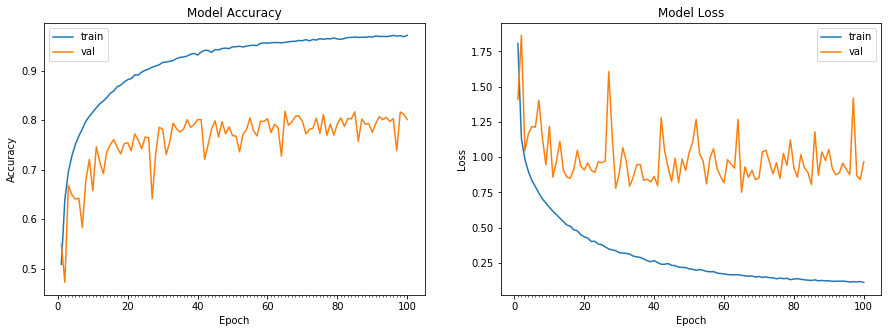

In [14]:

start = time.time()

# Train the model
# argument 'steps_per_epoch' defines how many times train_iterator will be asked for batches of training data
# argument 'validation_steps' defines how many times test_iterator will be asked for batches of validation data
# here validation is being performed in batches instead of one shot to avoid using up too much memory while training
model_info = model.fit_generator(train_iterator, steps_per_epoch = (len(train_features)//BS), epochs = 100, 
                                 validation_data = test_iterator, validation_steps = (len(test_features)//BS),
                                 callbacks=callbacks_list, verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

# plot model history
plot_model_history(model_info)


In [15]:
# Load Best saved model weights
model.load_weights(fileNameWeights, by_name=True)

# Since we have trained our model on Normalized input images, we must normalize the test data before predicting test accuracy
test_iterator = datagenTest.flow(test_features, test_labels, batch_size = test_features.shape[0])

# Obtain a batch a normalized test data
batchX, batchY = test_iterator.next()

# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(batchX, batchY, model))

Accuracy on test data is: 81.37
